<br></br>
# **Word / Doc 2 Vec**


<br></br>
# **1 Tensorflow 를 활용한 Word2Vec**

<br></br>
## **1 데이터 전처리**
베를린 선언문

In [1]:
f     = open('./data/베를린선언.txt', 'r')
texts_Berlin_raw = f.read()
f.close()
texts_Berlin = texts_Berlin_raw.split('\n\n')

In [2]:
import string
punct = string.punctuation
punct = [punct[i] for i in range(len(punct))]
punct = punct + ['\n', ')', '(']

for dump in punct: 
    texts_Berlin = [txt.replace(dump, '')    for txt in texts_Berlin]
print(len(texts_Berlin))

309


In [3]:
word_sequence = " ".join(texts_Berlin).split()
word_list     = " ".join(texts_Berlin).split()
word_list     = list(set(word_list))
word_dict     = {w: i for i, w in enumerate(word_list)}

<br></br>
## **2 Tensorflow  설정**
데이터 및 파라미터설정

In [4]:
import tensorflow as tf
import numpy as np

skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target  = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i-1]], word_dict[word_sequence[i+1]]]
    for w in context:
        skip_grams.append([target, w])

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성
def random_batch(data, size):
    random_inputs, random_labels = [], []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    for i in random_index:
        random_inputs.append(data[i][0])    # target
        random_labels.append([data[i][1]])  # context word
    return random_inputs, random_labels

In [6]:
training_epoch = 300
learning_rate  = 0.1
batch_size     = 20
embedding_size = 2   # 단어벡터 임베딩 차원 (x, y 2개만 출력)
num_sampled    = 15  # 모델의 nce_loss 샘플크기 (batch_size 보다 작아야 한다)
voc_size       = len(word_list) # 총 단어 갯수

<br></br>
## **3 Tensorflow  모델설정**
model Setting

In [7]:
inputs = tf.placeholder(tf.int32, shape=[batch_size])
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

embeddings     = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)
nce_weights    = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases     = tf.Variable(tf.zeros([voc_size]))

In [8]:
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

<br></br>
## **4 Tensorflow  Session 모델학습**
Session

In [9]:
%%time
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)
        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})
        if step % 30 == 0:
            print("loss at step ", step, ": ", loss_val)
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()

loss at step  30 :  43.146465
loss at step  60 :  47.521244
loss at step  90 :  25.933142
loss at step  120 :  21.644352
loss at step  150 :  21.509705
loss at step  180 :  19.634754
loss at step  210 :  26.798178
loss at step  240 :  15.058032
loss at step  270 :  7.3584085
loss at step  300 :  36.201984
CPU times: user 1.85 s, sys: 392 ms, total: 2.24 s
Wall time: 1.76 s


<br></br>
## **5 Visualization**
Session

In [10]:
%matplotlib inline
from matplotlib import font_manager, rc
font_fname = './data/D2Coding.ttf'     
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

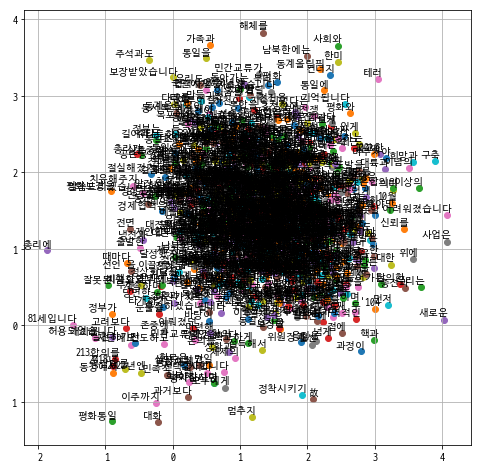

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.grid(True)
plt.show()

<br></br>
# **gensim | word2vec**
<br></br>
## **1 데이터 전처리**

In [12]:
%%time
# 텍스트를 한 줄씩 문법 tag를 추가한다
results, lines = [], texts_Berlin
from konlpy.tag import Okt
twitter = Okt()

for line in lines:
    malist = twitter.pos(line, norm=True, stem=True)
    result = [ word[0]   for word in malist    # 어미/조사/구두점 제외
               if not word[1] in ["Eomi", "Josa", "Punctuation"] ]
    rl = (" ".join(result)).strip()
    results.append(rl)
    
texts_file = './data/Berlin.tagged'
with open(texts_file, 'w', encoding='utf-8') as fp:
    fp.write("\n".join(results))

CPU times: user 11.5 s, sys: 213 ms, total: 11.7 s
Wall time: 4.06 s


In [13]:
! cat ./data/Berlin.tagged | head -n 5

존경 하다 독일 국민 여러분
고국 계시다 국민 여러분
하울 젠 쾨르버 재단 이사 님 모드 전 동독 총리 님 비롯 내외 귀빈 여러분
먼저 냉전 분단 넘다 통일 이루다
그 힘 유럽 통합 국제 평화 선도 있다


<br></br>
## **2 Word 2 vec 객체 만들기**
gensim

In [14]:
# ! pip3 install gensim

In [15]:
%%time
from gensim.models import word2vec
data  = word2vec.LineSentence(texts_file)
model = word2vec.Word2Vec(data, size=200, window=10, hs=1, min_count=2, sg=1)
model.save("./data/Berlin.model")
print("model saved.")

model saved.
CPU times: user 328 ms, sys: 47.9 ms, total: 376 ms
Wall time: 372 ms


<br></br>
## **3 저장된 객체 활용**
gensim

In [16]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('./data/Berlin.model')
model.wv.most_similar(positive=['한반도'])

/home/markbaum/Python/nltk/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.953595757484436),
 ('북한', 0.9391080141067505),
 ('이다', 0.9348244071006775),
 ('있다', 0.9343793392181396),
 ('것', 0.9262651205062866),
 ('적', 0.9237626791000366),
 ('되다', 0.9171555042266846),
 ('들', 0.9129030108451843),
 ('교류', 0.9068900346755981),
 ('군사', 0.9039526581764221)]

In [17]:
model.wv.most_similar(positive=['통일'])

/home/markbaum/Python/nltk/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.8907424211502075),
 ('것', 0.8707458972930908),
 ('있다', 0.8701075315475464),
 ('교류', 0.8683493137359619),
 ('이다', 0.8627951741218567),
 ('냉전', 0.8615832924842834),
 ('한반도', 0.8590165376663208),
 ('북한', 0.8567443490028381),
 ('적', 0.8552038669586182),
 ('들', 0.8472437858581543)]

In [18]:
model.wv.most_similar(positive=['정치'])

/home/markbaum/Python/nltk/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('분야', 0.9022226333618164),
 ('군사', 0.9020842909812927),
 ('적', 0.8918930888175964),
 ('교류', 0.8900008201599121),
 ('들', 0.8837994337081909),
 ('있다', 0.8837296962738037),
 ('사업', 0.8820741176605225),
 ('북한', 0.8811991214752197),
 ('협력', 0.8766742944717407),
 ('관계', 0.8730071783065796)]

<br></br>
## **04 Visulaization**
gensim

In [19]:
# model.wv.vocab : { word: object of numeric vector }
vocab = list(model.wv.vocab)
X = model[vocab]

/home/markbaum/Python/nltk/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [21]:
import pandas as pd
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.head()

,x,y
존경,-11.471402,-3.066151
하다,14.966725,20.022926
독일,10.393403,11.969556
국민,-5.042149,-10.903137
여러분,9.907387,8.741568


/home/markbaum/Python/nltk/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


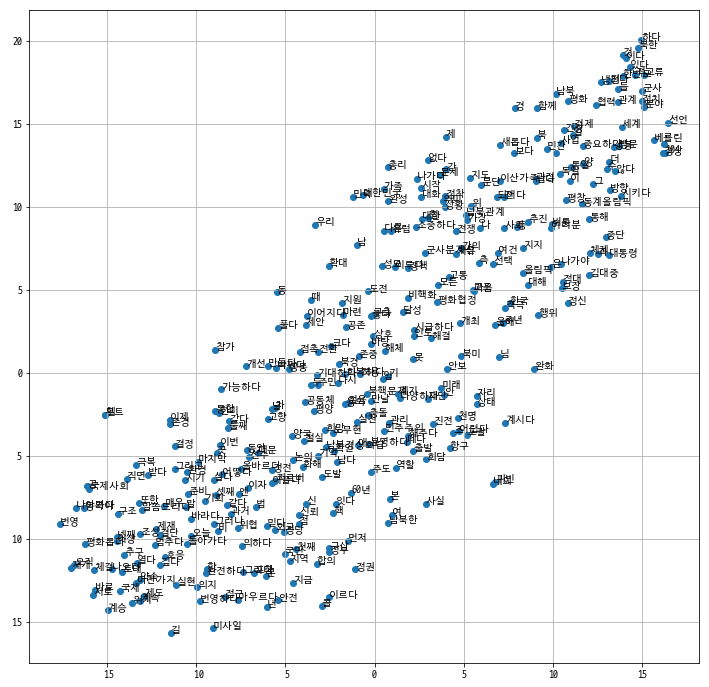

In [22]:
%matplotlib inline
from matplotlib import font_manager, rc
font_fname = './data/D2Coding.ttf'     
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.grid(True)
ax  = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)

<br></br>
# **gensim | doc2vec**
<br></br>
## **1 네이버 단어 전처리**
네이버 영화리뷰 단어모델 만들기

In [23]:
from konlpy.tag import Okt
twitter = Okt()

def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/10)) ]
    return random_data

def tokenize(doc):
  # norm, stem은 option 이었지만, konlpy 0.5 업데이트 이후로는 True 로 작업하자
  return ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)]

In [24]:
%%time
from collections import namedtuple
train_data        = read_data('data/ratings_train.txt')
train_docs        = [(tokenize(row[1]), row[2]) for row in train_data[1:]]
TaggedDocument    = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]

CPU times: user 46.4 s, sys: 124 ms, total: 46.5 s
Wall time: 40.6 s


In [25]:
from pprint import pprint
pprint(tagged_train_docs[0])

TaggedDocument(words=['제/Noun', '가/Josa', '알다/Verb', '성경/Noun', '말씀/Noun', '과/Josa', '다소/Noun', '다른/Noun', '부분/Noun', '은/Josa', '있다/Adjective', ',/Punctuation', '매우/Noun', '흥미롭다/Adjective', '자다/Verb', '보다/Verb', '^^/Punctuation'], tags=['1'])


<br></br>
## **2 doc2vec 파라미터 설정 및 학습**

In [26]:
%%time
from gensim.models import doc2vec
doc_vectorizer = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(tagged_train_docs)

for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs, 
                         total_examples = doc_vectorizer.corpus_count, 
                         epochs = doc_vectorizer.epochs)
    doc_vectorizer.alpha -= 0.002
    doc_vectorizer.min_alpha = doc_vectorizer.alpha 

# 학습이 완료된 모델의 데이터를 저장한다
doc_vectorizer.save('data/doc2vec.model')

CPU times: user 54.2 s, sys: 3.67 s, total: 57.9 s
Wall time: 28.1 s


<br></br>
## **3 doc2Vec 모델활용**

In [27]:
from gensim.models import doc2vec
from pprint import pprint
doc_vectorizer = doc2vec.Doc2Vec.load('data/doc2vec.model')
pprint(doc_vectorizer.wv.most_similar('공포/Noun'))

[('호러/Noun', 0.5042147636413574),
 ('코미디/Noun', 0.5023962259292603),
 ('스릴러/Noun', 0.48415499925613403),
 ('로맨틱/Noun', 0.46565741300582886),
 ('멜로/Noun', 0.4504464566707611),
 ('구름/Noun', 0.41685599088668823),
 ('쿨하다/Adjective', 0.41151463985443115),
 ('전/Foreign', 0.40736377239227295),
 ('장르/Noun', 0.40162017941474915),
 ('첩보/Noun', 0.3992690443992615)]


/home/markbaum/Python/nltk/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [28]:
pprint(doc_vectorizer.wv.most_similar('공포영화/Noun'))

[('액션영화/Noun', 0.5349124073982239),
 ('호러물/Noun', 0.466299831867218),
 ('로맨스영화/Noun', 0.45459824800491333),
 ('SF/Alpha', 0.4305993616580963),
 ('고질/Noun', 0.4273926019668579),
 ('국제/Noun', 0.42040616273880005),
 ('재난영화/Noun', 0.41976094245910645),
 ('트/Noun', 0.41786468029022217),
 ('히어로/Noun', 0.41377562284469604),
 ('스릴러/Noun', 0.40846002101898193)]


/home/markbaum/Python/nltk/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [29]:
pprint(doc_vectorizer.wv.similarity('공포/Noun', 'ㅋㅋ/KoreanParticle'))

0.025160823


/home/markbaum/Python/nltk/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [30]:
pprint(doc_vectorizer.wv.most_similar(positive=['여자/Noun', '최악/Noun'], 
                                      negative=['남자/Noun']))

[('짱/Noun', 0.3913077116012573),
 ('최고봉/Noun', 0.35023730993270874),
 ('최고/Noun', 0.3482310175895691),
 ('연속/Noun', 0.3236820101737976),
 ('명품/Noun', 0.32220274209976196),
 ('수작/Noun', 0.31401994824409485),
 ('여신/Noun', 0.31218934059143066),
 ('베스트/Noun', 0.30672574043273926),
 ('대박/Noun', 0.30204781889915466),
 ('리암/Noun', 0.3006420135498047)]


/home/markbaum/Python/nltk/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
